## Effect of Attention Heads and Layers on Model Performance

In [1]:
%cd ~/cil-text-classification/ 

/cluster/home/rarade/cil-text-classification


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning import Trainer

from core.data.io import *
from core.data.datasets import *
from core.data.tokenizers import *
from core.data.definitions import *
from core.utils.lime_utils import *
from core.utils.helper import *

In [3]:
EXPERIMENT_PATH = '/cluster/scratch/rarade/roberta-25-06-2020/'

model = load_model_from_experiment(EXPERIMENT_PATH)

Loading model  roberta-base


In [4]:
def show_plot(res, title='Accuracy'):
    res = np.around(res, 4)
    if len(res.shape) == 1:
        res = res.reshape(-1, 1)
    threshold = np.mean(res)-np.std(res)
    temp = np.ma.masked_less(res, threshold)
    
    plt.figure(figsize=(8, 5))
    fig, ax = plt.subplots()
    im = ax.imshow(temp, cmap='summer_r', interpolation='none')
    ax.set_yticks(np.arange(0, len(res), step=1))
    ax.set_yticklabels(np.arange(1, len(res)+1, step=1))
    if len(res.shape) > 1 and res.shape[1] != 1:
        ax.set_xticks(np.arange(0, len(res), step=1))
        ax.set_xticklabels(np.arange(1, len(res)+1, step=1))
    else:
        ax.set_xticks([])
    cbar = fig.colorbar(im, extend='min')
    cbar.cmap.set_under('white')

train, _ = load_datasets('in', full=True, clean=True)

val_preds = pd.read_csv(EXPERIMENT_PATH+'/val_with_logits.csv')
val_preds[ID_COL] = val_preds[ID_COL] - 1
val_preds.set_index(ID_COL, inplace=True)

val = train.iloc[val_preds.index]
del train

val[OUT_COL] = val[OUT_COL].apply(lambda x: -1 if x == 0 else 1)
print ('Validation accuracy: {}'\
       .format(np.sum(val.loc[val_preds.index, OUT_COL]==val_preds.loc[val_preds.index, 'Prediction'])/val_preds.shape[0]))

val_preds.head()

Validation accuracy: 0.90936


,Prediction,NegativeLogits,PositiveLogits
Id,,,
1812203,-1,4.028181,-3.644433
567831,1,-2.055248,2.570960
2480609,1,-0.939021,1.452965
746673,-1,4.020282,-3.616997
1429954,1,-0.802497,1.243536


In [5]:
val_input_ids, val_attn_mask = transformer_tokenize(val[IN_COL].values, model.tokenizer, 
                                                    max_seq_length=model.max_seq_length)

val_dataset = TransformerTestDataset(val_input_ids, val_attn_mask, val)
val_dataloader = DataLoader(dataset=val_dataset, sampler=SequentialSampler(val_dataset), 
                            batch_size=model.hparams.batch_size_validation, num_workers=model.hparams.workers)

Tokenizing text ... 
Tokenization completed!


In [6]:
NUM_HEADS = model.model.config.num_attention_heads
NUM_LAYERS = model.model.config.num_hidden_layers

trainer = Trainer(
    logger=False,
    gpus='-1' if torch.cuda.is_available() else None,
    show_progress_bar=False,
    distributed_backend=None,
    weights_summary=None,
    weights_save_path=None,
    progress_bar_refresh_rate=0
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


### Effect of disabling Roberta Layers

Masking Layer: 1
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.77656
Masking Layer: 2
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.90176
Masking Layer: 3
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.90432
Masking Layer: 4
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.902
Masking Layer: 5
Loading model

<Figure size 576x360 with 0 Axes>

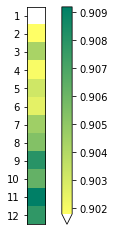

In [7]:
class MaskLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None,
        encoder_attention_mask=None, output_attentions=False,):
        outputs = ()
        outputs = (hidden_states,) + outputs
        return outputs

results = np.zeros(NUM_LAYERS)

for i in range(0, NUM_LAYERS):
    print ('Masking Layer: {}'.format(i+1))
    
    model = load_model_from_experiment(EXPERIMENT_PATH)

    # define some parameters to make it work
    model.total_steps = 15000
    model.trained = True
    model.hparams.log_dir = '/cluster/scratch/rarade/tmp/'
    model.hparams.soft_labels = False
    model.model.roberta.encoder.layer[i] = MaskLayer()
    
    seed()
    trainer.test(model, test_dataloaders=val_dataloader)
    
    preds = pd.read_csv(model.hparams.log_dir+'/submission.csv')
    preds[ID_COL] = preds[ID_COL] - 1
    preds.set_index(ID_COL, inplace=True)
    results[i] = accuracy_score(val[OUT_COL], preds['Prediction'])
    print ('Accuracy:, ', results[i])
    
show_plot(results)
plt.savefig('/cluster/scratch/rarade/plt2.png', bbox_inches='tight')

### Effect of Pruning Heads

Pruning Layer: 1. Head: 1
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.90864
Pruning Layer: 1. Head: 2
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.9084
Pruning Layer: 1. Head: 3
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0.90888
Pruning Layer: 1. Head: 4
Loading model  roberta-base
--------------------------------------------------------------------------------
TEST RESULTS
{}
--------------------------------------------------------------------------------
Accuracy:,  0

<Figure size 576x360 with 0 Axes>

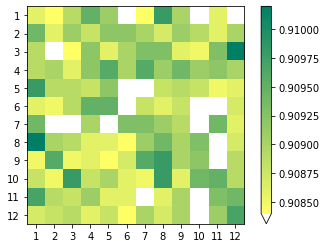

In [8]:
results = np.zeros((NUM_LAYERS, NUM_HEADS))

for i in range(0, NUM_LAYERS):
    for j in range(0, NUM_HEADS):
        print ('Pruning Layer: {}. Head: {}'.format(i+1, j+1))

        heads_to_prune = {
            i: [j]
        }
        model = load_model_from_experiment(EXPERIMENT_PATH)

        # define some parameters to make it work
        model.total_steps = 15000
        model.trained = True
        model.hparams.log_dir = '/cluster/scratch/rarade/tmp/'
        model.hparams.soft_labels = False
        
        model.model.cuda()
        model.model.prune_heads(heads_to_prune)
        seed()
        trainer.test(model, test_dataloaders=val_dataloader)

        preds = pd.read_csv(model.hparams.log_dir+'/submission.csv')
        preds[ID_COL] = preds[ID_COL] - 1
        preds.set_index(ID_COL, inplace=True)
        results[i, j] = accuracy_score(val[OUT_COL], preds['Prediction'])
        print ('Accuracy:, ', results[i, j])
        
show_plot(results)
plt.savefig('/cluster/scratch/rarade/plt3.png', bbox_inches='tight')